#### [ IRIS 꽃받침 길이, 너비, 꽃잎 길이기반 꽃잎 너비 예측 모델 + 교차검증 ]
- 데이터셋 : iris.csv
- 학습종류 : 지도학습 / 회귀(Regression) 
- 알고리즘 : 분석 후 결정 
- 피쳐 : 꽃받침 길이, 꽃받침 너비, 꽃잎 길이  ==> 다변량 
- 타겟 : 꽃잎 너비
- 검증 : 5개 교차검증 진행 

[1] 모듈 로딩 및 데이터 준비 <hr>

In [3]:
## [1-1] 모듈로딩 
import pandas as pd                                             ## 데이터 분석 및 전처리용 모듈
import matplotlib.pyplot as plt                                 ## 데이터 시각화
from sklearn.model_selection import train_test_split            ## 학습용 / 검증용 / 테스트용 데이터 분리 및 처리용 모듈
from sklearn.model_selection import KFold                       ## 교차검증


In [4]:
## [1-2] 데이터 준비
DATA_FILE = '../data/iris.csv' 

In [5]:
## - "sepal.length","sepal.width","petal.length","petal.width" 4개 컬럼만 추출
irisDF = pd.read_csv(DATA_FILE, usecols=[0,1,2,3])
irisDF.head()

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


[2] 데이터 분석 - 탐색적 데이터 분석 <hr>

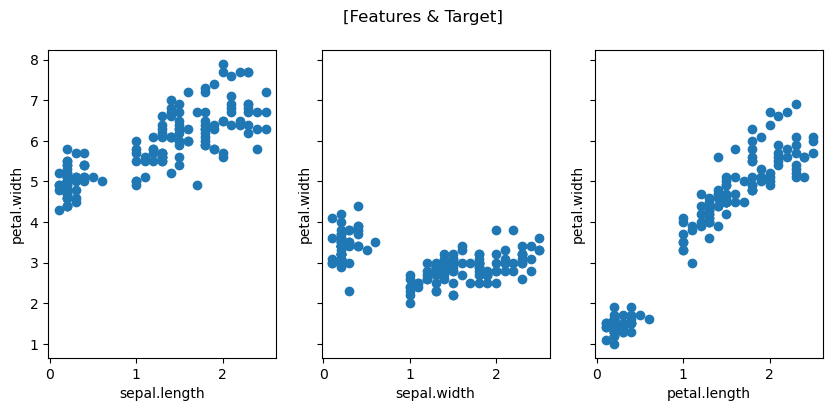

In [6]:
## 시각화 
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(10, 4))

axes = axes.flatten()
titles = irisDF.columns[:-1]

for title, ax in zip(titles, axes):
    ax.scatter(irisDF['petal.width'], irisDF[title])
    ax.set_xlabel(title)
    ax.set_ylabel('petal.width')
plt.suptitle("[Features & Target]")
plt.show()

In [7]:
## - 수치화 
irisDF.corr()['petal.width']

sepal.length    0.817941
sepal.width    -0.366126
petal.length    0.962865
petal.width     1.000000
Name: petal.width, dtype: float64

- 탐색적 데이터 분석 결과
    * 데이터 분포 분석 : sepal.length, petal.length 따른 너비가 증가하는 양상 보임
    * 데이터 상관 계수 : sepal.length, petal.length가 관계성이 높음 
    * 알고리즘 : 선형 회귀로 진행 
    * 선택피쳐 : sepal.length, petal.length

[3] 데이터셋 준비 <hr>
- 학습용 데이터셋 : 학습에만 사용되는 데이터셋 => 해당 데이터셋에서 피쳐와 타겟의 규칙/패턴 찾기 
- 검증용 데이터셋 : 학습 중 규칙/패턴 제대로 학습 여부 검사용 
- 테스트용 데이터셋 : 모델 완성 후 테스트용 데이터셋
- Scikit-learn 패키지 특성으로 학습용과 테스트용만 사용 

In [8]:
## [3-1] 피쳐와 타겟 분리 
featureDF = irisDF[irisDF.columns[:-1:2]]
targetSR = irisDF[irisDF.columns[-1]]

print(f'featureDF => {featureDF.ndim}D  ,  {featureDF.shape}')
print(f'targetSR  => {targetSR.ndim}D  ,  {targetSR.shape}')

featureDF => 2D  ,  (150, 2)
targetSR  => 1D  ,  (150,)


In [9]:
## [3-2] 학습용과 테스트용 데이터셋 분리 => 학습용 : 테스트용 = 75% : 25%
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR,
                                                    random_state=5)

In [10]:
print(f'X_train => {X_train.ndim}D  ,  {X_train.shape} | y_train => {y_train.ndim}D  ,  {y_train.shape}')
print(f'X_test  => {X_test.ndim}D  ,  {X_test.shape}  | y_test  => {y_test.ndim}D  ,  {y_test.shape}')

X_train => 2D  ,  (112, 2) | y_train => 1D  ,  (112,)
X_test  => 2D  ,  (38, 2)  | y_test  => 1D  ,  (38,)


[4] 학습 진행 <hr>

In [11]:
## 모듈로딩
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet                                             ## 알고리즘 모듈
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error  ## 성능평가 관련 모듈

In [12]:
## 교차검증 객체 생성 - 5개 분할 [기본]
kf = KFold()

## 선형회귀 모델 객체 생성 
lr = Ridge()

In [26]:
## 교차검증으로 학습 및 검증 진행

resultDF = pd.DataFrame(columns=['score','loss'])

for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    ## - 학습용/테스트용 피쳐와 타겟 추출
    train_data, train_label = X_train.iloc[train_index],  y_train.iloc[train_index] 
    test_data, test_label   = X_train.iloc[test_index],  y_train.iloc[test_index] 

    ## - 학습
    lr.fit(train_data, train_label)

    ## - 성능평가
    train_score=lr.score(train_data, train_label)
    test_score =lr.score(test_data, test_label)

    ## - 손실계산
    train_loss=root_mean_squared_error(train_label, lr.predict(train_data))
    test_loss =root_mean_squared_error(test_label, lr.predict(test_data))

    ## - 결과 행 추가 
    resultDF.loc[f'Train{i}']=[train_score, train_loss]
    resultDF.loc[f'Test{i}']=[test_score, test_loss]
    break

## - 결과 확인
resultDF


,score,loss
Train0,0.928952,0.206928
Test0,0.952178,0.158973


[5] 테스트 수행 <hr>
- 테스트 데이터셋 진행

In [27]:
from sklearn.metrics import r2_score

In [28]:
X_train, X_test

(     sepal.length  petal.length
 40            5.0           1.3
 115           6.4           5.3
 142           5.8           5.1
 69            5.6           3.9
 17            5.1           1.4
 ..            ...           ...
 8             4.4           1.4
 73            6.1           4.7
 144           6.7           5.7
 118           7.7           6.9
 99            5.7           4.1
 
 [112 rows x 2 columns],
      sepal.length  petal.length
 82            5.8           3.9
 134           6.1           5.6
 114           5.8           5.1
 42            4.4           1.3
 109           7.2           6.1
 57            4.9           3.3
 1             4.9           1.4
 70            5.9           4.8
 25            5.0           1.6
 84            5.4           4.5
 66            5.6           4.5
 133           6.3           5.1
 102           7.1           5.9
 107           7.3           6.3
 26            5.0           1.6
 23            5.1           1.7
 123           6

In [29]:
## 테스트 데이터에 대한 예측값 추출 
pre_=lr.predict(X_test)

## 평가 
score=r2_score(y_test, pre_)
rmse=root_mean_squared_error(y_test, pre_)



[6] 모델 활용 / 서비스 <hr>

In [30]:
## 사용자로부터 입력 받기
print("[품종 조회]--------------")
new_data = input("입력 (예: 3.4,7.9) : ").split(',')
print(new_data)

new_data = [ float(data) for data in new_data ]
print(new_data)

[품종 조회]--------------
['9.8', '12.4']
[9.8, 12.4]


In [31]:
## 예측결과 출력
dataDF=pd.DataFrame([new_data], columns=['sepal.length', 'petal.length'])
dataDF

,sepal.length,petal.length
0,9.8,12.4


In [32]:
## 테스트 데이터에 대한 예측값 추출 
pre_=lr.predict(dataDF)

pre_


array([4.77040195])